In [134]:
# Import
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
warnings.filterwarnings('ignore')
%matplotlib inline

dirpath = '../data/'

In [22]:
# Load data
customers = pd.read_csv(dirpath+"olist_customers_dataset.csv")
order_payments = pd.read_csv(dirpath+"olist_order_payments_dataset.csv")
orders = pd.read_csv(dirpath+"olist_orders_dataset.csv")

# Join
customer_order = customers.merge(orders, on='customer_id', how='left')
order_payments = order_payments.groupby('order_id').sum().reset_index()[['order_id','payment_value']]
cop = customer_order.merge(order_payments, on='order_id', how='left')

# clean and format
cop['order_purchase_timestamp'] = pd.to_datetime(cop['order_purchase_timestamp'])
cop = cop[cop['order_status']!='canceled']

In [23]:
customer_order.groupby('customer_unique_id').size().value_counts()

1     93099
2      2745
3       203
4        30
5         8
6         6
7         3
17        1
9         1
dtype: int64

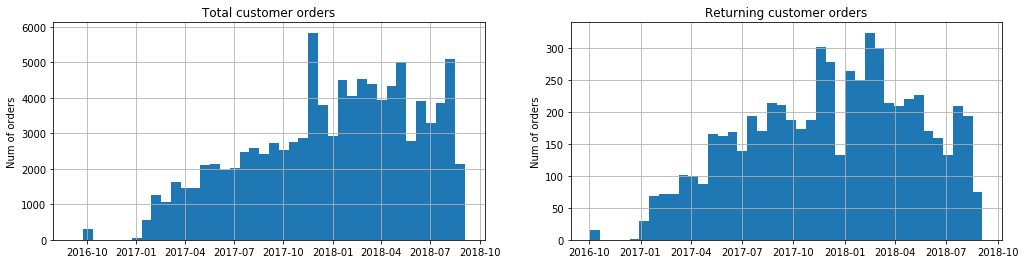

In [24]:
plt.figure(figsize=(17, 4))
    
plt.subplot(1, 2, 1)
plt.title('Total customer orders')
plt.ylabel('Num of orders')
cop.order_purchase_timestamp.hist(bins=40)

plt.subplot(1, 2, 2)
plt.ylabel('Num of orders')
plt.title('Returning customer orders')
unique_id = cop.groupby('customer_unique_id').count()
later_purchase = cop[cop.customer_unique_id.isin(list(unique_id[unique_id.customer_id > 1].index))]
later_purchase.order_purchase_timestamp.hist(bins=40)
plt.show()

In [57]:
# Helper functions
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

def plot_cluster(data, name):
    sse={}
    for k in range(1, 10):
        kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data)
        sse[k] = kmeans.inertia_ 
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.title('Optimal number of clusters via Elbow of: ' + name)
    plt.xlabel("Number of cluster")
    plt.ylabel("Inertia")
    plt.show()

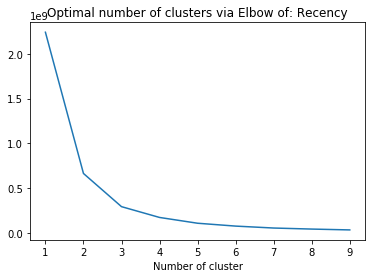

In [58]:
# Recency
df_recency = cop.groupby('customer_unique_id').order_purchase_timestamp.max().reset_index()
df_recency.columns = ['customer_unique_id','last_purchase_date']
df_recency['Recency'] = (df_recency['last_purchase_date'].max() - df_recency['last_purchase_date']).dt.days
df_recency = df_recency[['customer_unique_id','Recency']]

# Frequency
df_frequency = cop.groupby('customer_unique_id').order_purchase_timestamp.count().reset_index()
df_frequency.columns = ['customer_unique_id','Frequency']

# Revenue
df_revenue = cop.groupby('customer_unique_id').payment_value.sum().reset_index()
df_revenue.columns = ['customer_unique_id','Revenue']

df = pd.DataFrame(cop['customer_unique_id'].unique())
df.columns = ['customer_unique_id']

sort_orders = [False, True, True]
names = ['Recency','Frequency','Revenue']
dfs = [df_recency, df_frequency, df_revenue]

for i in range(len(['Recency','Frequency','Revenue'])):
    df = pd.merge(df, dfs[i], on='customer_unique_id')
    kmeans = KMeans(n_clusters=4)
    
    if names[i] == "Recency":
        plot_cluster(df[[names[i]]], names[i])
        
    kmeans.fit(df[[names[i]]])
    df['cluster_' + names[i]] = kmeans.predict(df[[names[i]]])
    df = order_cluster('cluster_' + names[i], names[i], df, sort_orders[i])
    
df['OverallScore'] = df['cluster_Recency'] + df['cluster_Frequency'] + df['cluster_Revenue']

In [47]:
overview = df.groupby('OverallScore')['Recency','Frequency','Revenue'].mean()
overview['Count'] = df.groupby('OverallScore')['customer_unique_id'].count()
overview

,Recency,Frequency,Revenue,Count
OverallScore,,,,
0,488.053662,1.000000,91.038309,13231
1,341.884333,1.008584,120.275769,22366
2,217.465755,1.018964,142.306897,26471
3,102.017039,1.029044,167.245919,25823
4,97.419890,1.144612,399.062099,6023
5,88.231959,1.441090,776.290007,1358
6,76.930894,1.841463,1525.675244,246
7,104.666667,3.545455,1140.622424,33
8,52.888889,6.666667,1610.453333,9


In [44]:
df['Segment'] = 'Low-Value'
df.loc[df['OverallScore']>1,'Segment'] = 'Mid-Value' 
df.loc[df['OverallScore']>3,'Segment'] = 'High-Value' 

plot = df[(df['Revenue']<7000) & (df['Frequency']<6)]

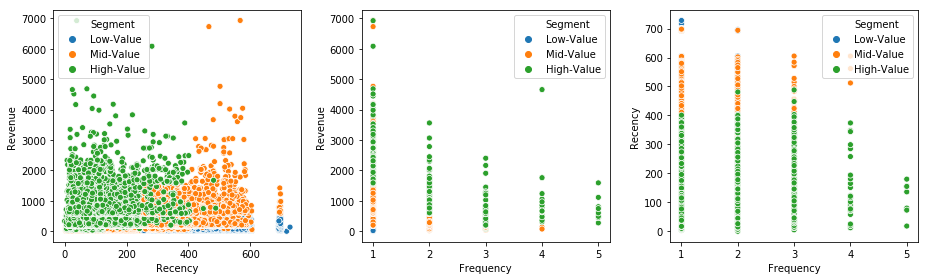

In [46]:
plt.figure(figsize=(13, 4))
    
ax0_names = ['Recency','Frequency','Frequency']
ax1_names = ['Revenue','Revenue','Recency']

for i in range(3):
    plt.subplot(1, 3, i+1)
    sns.scatterplot(ax0_names[i], ax1_names[i], hue='Segment', data=plot)

plt.tight_layout()
plt.show()

# Customer Lifetime Value

we have chosen The lifetime value (LTV) to be 6 months so the period will be from the 01/01/2018 - 01/06/2018
and we take 12 months of data to calculate the RFM and use it for predicting the next 6 months. The 12-month period will stretch from 01/01/2017 - 01/01/2018

In [59]:
from datetime import datetime, timedelta, date
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

In [64]:
# Create 12m and 6m dataframes
tx_12m = cop[(cop.order_purchase_timestamp < pd.Timestamp(2017,8,1)) & (cop.order_purchase_timestamp >= pd.Timestamp(2017,1,1))].reset_index(drop=True)
tx_6m = cop[(cop.order_purchase_timestamp >= pd.Timestamp(2017,8,1)) & (cop.order_purchase_timestamp < pd.Timestamp(2018,6,1))].reset_index(drop=True)

In [96]:
# Recency 12m
df_recency = tx_12m.groupby('customer_unique_id').order_purchase_timestamp.max().reset_index()
df_recency.columns = ['customer_unique_id','last_purchase_date']
df_recency['Recency'] = (df_recency['last_purchase_date'].max() - df_recency['last_purchase_date']).dt.days
df_recency = df_recency[['customer_unique_id','Recency']]

# Frequency 12m
df_frequency = tx_12m.groupby('customer_unique_id').order_purchase_timestamp.count().reset_index()
df_frequency.columns = ['customer_unique_id','Frequency']

# Revenue 12m
df_revenue = tx_12m.groupby('customer_unique_id').payment_value.sum().reset_index()
df_revenue.columns = ['customer_unique_id','Revenue']

df_12m = pd.DataFrame(tx_12m['customer_unique_id'].unique())
df_12m.columns = ['customer_unique_id']

sort_orders = [False, True, True]
names = ['Recency','Frequency','Revenue']
dfs = [df_recency, df_frequency, df_revenue]

for i in range(len(['Recency','Frequency','Revenue'])):
    df_12m = pd.merge(df_12m, dfs[i], on='customer_unique_id')
    kmeans = KMeans(n_clusters=4)        
    kmeans.fit(df_12m[[names[i]]])
    df_12m['cluster_' + names[i]] = kmeans.predict(df_12m[[names[i]]])
    df_12m = order_cluster('cluster_' + names[i], names[i], df_12m, sort_orders[i])
    
df_12m['OverallScore'] = df_12m['cluster_Recency'] + df_12m['cluster_Frequency'] + df_12m['cluster_Revenue']

In [97]:
df_12m['Segment'] = 'Low-Value'
df_12m.loc[df['OverallScore']>1,'Segment'] = 'Mid-Value' 
df_12m.loc[df['OverallScore']>3,'Segment'] = 'High-Value' 

plot = df_12m[(df_12m['Revenue']<7000) & (df_12m['Frequency']<6)]

### 6 month LTV

Now the 6 month LTV is calculated for each customer

In [98]:
tx_user_6m.head()

,customer_unique_id,m6_Revenue
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19
2,0000f6ccb0745a6a4b88665a16c9f078,43.62
3,0004aac84e0df4da2b147fca70cf8255,196.89
4,0004bd2a26a76fe21f786e4fbd80607f,166.98


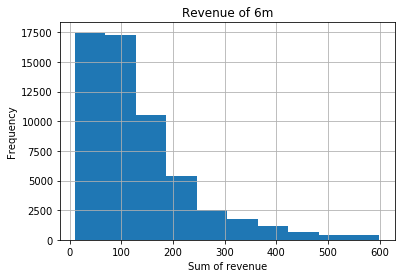

In [99]:
# Calculate revenue and create a new dataframe for it
tx_user_6m = tx_6m.groupby('customer_unique_id')['payment_value'].sum().reset_index()
tx_user_6m.columns = ['customer_unique_id','m6_Revenue']

# Plotting
tx_user_6m['m6_Revenue'][tx_user_6m['m6_Revenue']<600].hist()
plt.ylabel('Frequency')
plt.xlabel('Sum of revenue')
plt.title('Revenue of 6m')
plt.show()

Now we will merge our 3 months and 6 months dataframes to see correlations between LTV and the features set we have - (taget fra nettet skal ændres!)

In [100]:
tx_merge = pd.merge(df_12m, tx_user_6m, on='customer_unique_id', how='left')
#tx_merge = tx_merge.fillna(0)

tx_merge.head()
#insert scatter plot her af RFM score vs 6m LTV

,customer_unique_id,Recency,cluster_Recency,Frequency,cluster_Frequency,Revenue,cluster_Revenue,OverallScore,Segment,m6_Revenue
0,861eff4711a542e4b93843c6dd7febb0,76,2,1,0,146.87,0,2,Mid-Value,NaN
1,7f3a72e8f988c6e735ba118d54f47458,81,2,1,0,102.03,0,2,Mid-Value,NaN
2,2e6a42a9b5cbb0da62988694f18ee295,77,2,1,0,47.59,0,2,Mid-Value,NaN
3,fd2d5fdb84e65fa6b54b98b0e2df5645,70,2,1,0,80.57,0,2,Mid-Value,NaN
4,8728c766c84eeda24b3e54fe6e632051,63,2,1,0,144.26,0,2,Mid-Value,NaN


In [101]:
#remove outliers
tx_merge = tx_merge[tx_merge['m6_Revenue']<tx_merge['m6_Revenue'].quantile(0.99)]

#creating 3 clusters
kmeans = KMeans(n_clusters=3)
kmeans.fit(tx_merge[['m6_Revenue']])
tx_merge['LTVCluster'] = kmeans.predict(tx_merge[['m6_Revenue']])

#order cluster number based on LTV
tx_merge = order_cluster('LTVCluster', 'm6_Revenue',tx_merge,True)

#creatinga new cluster dataframe
tx_cluster = tx_merge.copy()

#see details of the clusters
tx_cluster.groupby('LTVCluster')['m6_Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
LTVCluster,,,,,,,,
0,306.0,92.307647,42.910670,14.08,56.9825,87.025,125.940,178.43
1,87.0,264.695287,63.364032,179.26,206.7500,262.160,316.555,417.74
2,19.0,587.331053,112.030922,453.80,498.6950,556.860,677.325,830.64


In [102]:
tx_cluster.head()

,customer_unique_id,Recency,cluster_Recency,Frequency,cluster_Frequency,Revenue,cluster_Revenue,OverallScore,Segment,m6_Revenue,LTVCluster
0,18e3d276253780b44b5b7bf83f6785ec,89,2,1,0,96.88,0,2,Mid-Value,71.97,0
1,49d1599dd80dedc213037342bbe43fd7,59,2,1,0,40.77,0,2,Mid-Value,77.80,0
2,54c7b4f48fb9e911bf328bf9884ca61d,49,2,1,0,92.37,0,2,Mid-Value,92.37,0
3,2b952792a20f6076f6e7a9c6a27ade02,56,2,1,0,47.54,0,2,Mid-Value,82.60,0
4,cb4253d36367737b6baa4f8ca58fac62,47,2,1,0,83.14,0,2,Mid-Value,59.66,0


In [103]:
#convert categorical columns to numerical
tx_class = pd.get_dummies(tx_cluster, columns=['Segment'])

In [104]:
#calculate and show correlations
corr_matrix = tx_class.corr()
corr_matrix['LTVCluster'].sort_values(ascending=False)

LTVCluster            1.000000
m6_Revenue            0.896953
cluster_Revenue       0.208782
Revenue               0.186529
Segment_High-Value    0.166366
cluster_Frequency     0.134530
Frequency             0.133496
OverallScore          0.081375
Segment_Low-Value     0.013241
Recency               0.004904
cluster_Recency      -0.020125
Segment_Mid-Value    -0.099363
Name: LTVCluster, dtype: float64

In [136]:
from sklearn.preprocessing import MinMaxScaler

#create X and y, X will be feature set and y is the label - LTV
X = tx_class.drop(['customer_unique_id','LTVCluster','m6_Revenue'],axis=1)
y = tx_class['LTVCluster']

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

#split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=56)

### Dummy baseline

Having a high class imbalance we first create a baseline "dummy" classifier to later compare with a more advanced model.

In [170]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report

clf = DummyClassifier(random_state=0).fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.59      0.67        17
           1       0.17      0.50      0.25         2
           2       0.00      0.00      0.00         2

   micro avg       0.52      0.52      0.52        21
   macro avg       0.31      0.36      0.31        21
weighted avg       0.64      0.52      0.56        21



### Logistic regression 

Creating a simple classifier to later compare with a more advanced model

In [171]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, solver='lbfgs',
                          multi_class='multinomial').fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      1.00      0.89        17
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         2

   micro avg       0.81      0.81      0.81        21
   macro avg       0.27      0.33      0.30        21
weighted avg       0.66      0.81      0.72        21



### ANN Classifier

Creating a simple classifier to later compare with a more advanced model

In [181]:
# multi-class classification with Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import np_utils

train_cat_y = np_utils.to_categorical(y_train)

# define baseline model
model = Sequential()
model.add(Dense(100, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(20, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
 
model.summary()
    
model.fit(X_train, train_cat_y, epochs = 10)    
y_pred = model.predict_classes(X_test)

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 100)               1100      
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_44 (Dense)             (None, 20)                2020      
_________________________________________________________________
dense_45 (Dense)             (None, 3)                 63        
Total params: 3,183
Trainable params: 3,183
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
391/391 [==============================] - 1s 4ms/step - loss: 1.0144 - accuracy: 0.5499
Epoch 2/10
391/391 [==============================] - 0s 256us/step - loss: 0.8560 - accuracy: 0.7289
Epoch 3/10
391/391 [===========================

In [179]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      1.00      0.89        17
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         2

   micro avg       0.81      0.81      0.81        21
   macro avg       0.27      0.33      0.30        21
weighted avg       0.66      0.81      0.72        21

